In [33]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
cutoff_value = 0.99

In [34]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

random.seed(0)

print("Running...")


thr_std=0.2

E = Events("CheatedRecoFile_1.root")

view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")

u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x

v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

Running...


In [35]:
def importpdf(filename):
    df = pd.read_csv(filename)
    df = df.fillna(0)
    data = df.values
    return data[0][1:], data[1][1:]

In [36]:
def normalisepdfs(signal_data_path, background_data_path):
    background_hist_values, background_bin_values = importpdf(background_data_path)
    background_hist_values = np.nan_to_num(background_hist_values)
    background_hist_values = background_hist_values.astype(np.float64)
    background_bin_values = background_bin_values.astype(np.float64)
    background_bin_values = np.nan_to_num(background_bin_values)
    
    signal_hist_values, signal_bin_values = importpdf(signal_data_path)
    signal_hist_values = np.nan_to_num(signal_hist_values)
    signal_hist_values = signal_hist_values.astype(np.float64)
    signal_bin_values = signal_bin_values.astype(np.float64)
    signal_bin_values = np.nan_to_num(signal_bin_values)
    
    #print(background_hist_values, signal_hist_values)
    total_hist_values = background_hist_values + signal_hist_values
    #print("\n", total_hist_values)
    
    normalised_background = background_hist_values[:-1] / total_hist_values[:-1]
    normalised_signal = signal_hist_values[:-1] / total_hist_values[:-1]
    
    return normalised_signal, signal_bin_values[:-1], normalised_background, background_bin_values[:-1]

In [37]:
def plotpdf(normalised_signal, signal_bin_values, normalised_background, background_bin_values):
    plt.title("Signal (red) - Background (blue) PDFs")
    plt.xlabel("Normalised Metric Score")
    plt.ylabel("PDF Probability")
    plt.plot(signal_bin_values, normalised_signal, '.r-')
    plt.plot(background_bin_values, normalised_background, '.b-')
    plt.show()
    return 0

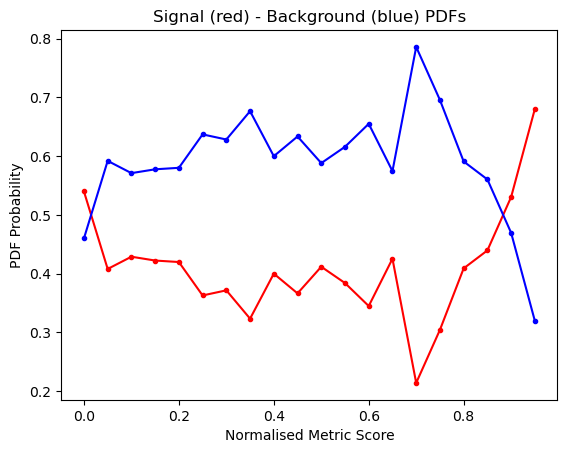

0

In [58]:
normalised_signal, signal_bin_values, normalised_background, background_bin_values = normalisepdfs("signal_quad_hist2.csv", "back_quad_hist2.csv")
plotpdf(normalised_signal, signal_bin_values, normalised_background, background_bin_values)

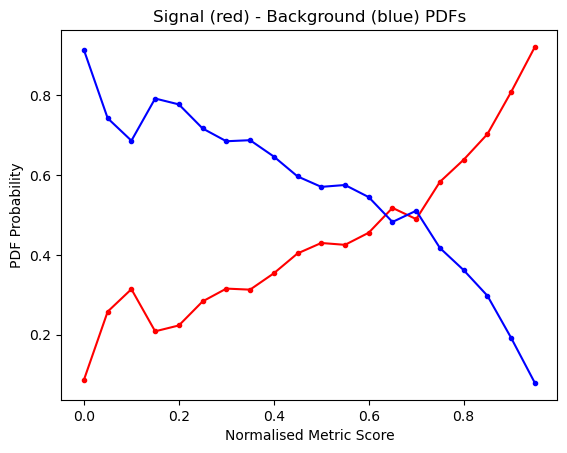

0

In [39]:
normalised_signal, signal_bin_values, normalised_background, background_bin_values = normalisepdfs("signal_lz_hist.csv", "back_lz_hist.csv")
plotpdf(normalised_signal, signal_bin_values, normalised_background, background_bin_values)

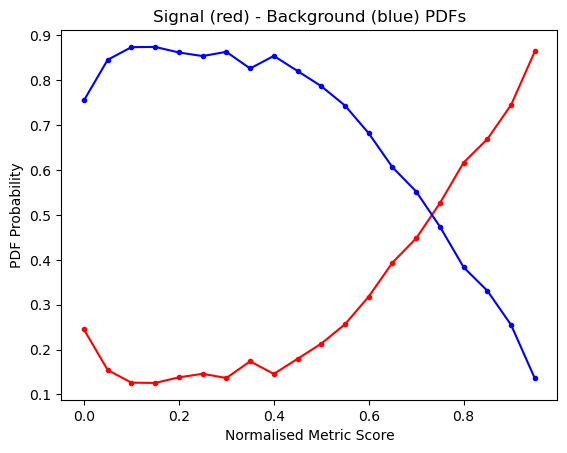

0

In [40]:
normalised_signal, signal_bin_values, normalised_background, background_bin_values = normalisepdfs("signal_rphi_hist.csv", "back_rphi_hist.csv")
plotpdf(normalised_signal, signal_bin_values, normalised_background, background_bin_values)

In [41]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


# Least Z Probability Calculation

In [42]:
def least_z_scores(plane, event):
    x_view, z_view, adc_view, true_z, true_x = AoI(plane, event)
    z_scores = [None] * len(x_view)
    min_z = np.amin(z_view)
    ind = np.where(min_z)[0]
    min_x = x_view[ind]
    for i in range(len(x_view)):
        z_scores[i] = z_view[ind] - z_view[i]
    
    score_max = max(z_scores)
    score_min = min(z_scores)
    
    normalised_scores = (z_scores - score_min) / (score_max - score_min)
    
    return normalised_scores

In [43]:
import scipy as sp
def calculate_probability_lz(plane, event, vertex):
    score = least_z_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_lz_hist.csv", "back_lz_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value
    
    return prob


# RPHI Probability Calculation

In [44]:
def rfunc(r):
    return 1/((r+0.01)**(1/2))

def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=5, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    #make the problem tractable (solvable)
    
    weight = rfunc(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    return norm_score

def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in range(no_points):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind], score_arr

def rphi_scores(plane, event_number, function=optimise_phi, dependence=np.exp, plot=False, thresholding=True, no_std=thr_std, no_sectors=5):
    AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, event_number, thresholding, no_std)
    Zvert_place, Xvert_place = function(plane, event_number, no_sectors)[0], function(plane, event_number, no_sectors)[1]
    score_max, score_array = function(plane, event_number, no_sectors)[2], function(plane, event_number, no_sectors)[3]
    
    score_min = np.min(score_array)
    
    normalised_scores = (score_array - score_min) / (score_max - score_min)
    
    if plot:
        plt.plot(AoI_z, AoI_x, 'o')
        plt.show()
        plt.plot(AoI_z, normalised_scores, 'ro')
        plt.show()
    return normalised_scores


In [45]:
import scipy as sp
def calculate_probability_rphi(plane, event, vertex):
    score = rphi_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_rphi_hist.csv", "back_rphi_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value

    return prob

# QuadVertex Probability Calculation

In [46]:
def line_finder(point1, point2):
    slope = (point1[1] - point2[1])/(point1[0] - point2[0])
    intercept = point1[1] - slope * point1[0]
    return slope, intercept

def line_intersect(slope1, intercept1, slope2, intercept2):
    x_point = (intercept2 - intercept1)/(slope1 - slope2)
    z_point = slope1 * x_point + intercept1
    return x_point, z_point

def check_valid_intersection(point1, point2, point3, point4, range_x, range_z):
    slope1, intercept1 = line_finder(point1, point2)
    slope2, intercept2 = line_finder(point3, point4)
    x_point, z_point = line_intersect(slope1, intercept1, slope2, intercept2)
    x_vertices = [point1[0], point2[0], point3[0], point4[0]]
    z_vertices = [point1[1], point2[1], point3[1], point4[1]]
    x_max, x_min = max(x_vertices), min(x_vertices)
    z_max, z_min = max(z_vertices), min(z_vertices)
    angle1, angle2 = np.arctan(slope1), np.arctan(slope2)
    if x_point > x_min and x_point < x_max:
        if z_point > z_min and z_point < z_max:
            if angle1 < 0.8*angle2 or angle1 > 1.25*angle2: 
                return x_point, z_point
            else:
                return "fail 1", angle1, angle2
        else:
            return "fail 2"
    else:
        return "fail 3"

def get_valid_points(point1, point2, point3, point4, range_x, range_z):
    initial_vertices = [0, 0]
    try:
        initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point2, point3, point4, range_x, range_z)
        #print("V1")
        return initial_vertices
    except:
        try:
            initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point3, point2, point4, range_x, range_z)
            #print("V2")
            return initial_vertices
        except:
            try:
                initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point4, point2, point3, range_x, range_z)
                #print("V3")
                return initial_vertices
            except:
                #print("Fail", point1, point2, point3, point4) 
                return False

def select_random_points(AoI_x, AoI_z, AoI_adc, iterations="scaled", no_std=thr_std):
    if iterations == "scaled":
        iterations = int((len(AoI_x))*4)
        initial_vertex_points = np.zeros((iterations, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                try:
                    initial_vertex_points[i, 0], initial_vertex_points[i, 1] = get_valid_points(point1, point2, point3, point4, range_x, range_z)
                except:
                    pass
                '''
                print("Sample: ", sample)
                print("Slope 1: ", slope1)
                print("Slope 2: ", slope2)
                print("Intercept 1: ", intercept1)
                print("Intercept 2: ", intercept2)
                print("$$$$$$$$    X-point, Z-point    $$$$$$$$: ", x_point, y_point)
                '''
    else:
        initial_vertex_points = np.zeros((iterations, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                try:
                    initial_vertex_points[i, 0], initial_vertex_points[i, 1] = get_valid_points(point1, point2, point3, point4, range_x, range_z)
                except:
                    pass
    return initial_vertex_points

def heatmap4points(plane, event_number, thresholding=False, no_std=thr_std, iterations=10000, bins=100):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    vertex_points = select_random_points(AoI_x, AoI_z, AoI_adc, iterations)
    #print(vertex_points)
    vertex_points = vertex_points[~np.all(vertex_points == 0, axis=1)] #removes all the 0,0 vertices
    
    #print(vertex_points)
    histvertex = plt.hist2d(vertex_points[:,1], vertex_points[:,0], bins=(bins, bins), cmap=plt.cm.jet)
    plt.title(str(plane) + str(event_number))
    #stringy = str(plane) + str(event_number) + ".png"
    #plt.savefig(stringy)
    #plt.show()
    
    histogram_array = histvertex[0]
    #print(histogram_array)
    max_value = np.amax(histogram_array)
    indices = np.where(histogram_array == max_value)
    #print("Indices: ", indices)
    z_value = histvertex[1][indices[0]]
    x_value = histvertex[2][indices[1]]
    #print("Z_value: ", z_value)
    #print("X_value: ", x_value)

    return z_value[0], x_value[0], histogram_array, histvertex[1], histvertex[2]

def quadvertex_scores(plane, event_number, binwidth=(100,100), binradius=3):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number)
    
    h, zedges, xedges = heatmap4points(plane, event_number)[2], heatmap4points(plane, event_number)[3], heatmap4points(plane, event_number)[4]

    zbins = np.digitize(AoI_z, zedges) - 2 
    xbins = np.digitize(AoI_x, xedges) - 2
    
    zxbins = np.concatenate((zbins[...,None],xbins[...,None]), axis=1) 
    
    weights = h[zxbins[:,0], zxbins[:,1]]
    
    scores = weights/np.amax(weights)
    return scores


In [47]:
import scipy as sp
def calculate_probability_quad(plane, event, vertex):
    score = quadvertex_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_quad_hist.csv", "back_quad_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value
    
    return prob

# Full Likelihood Calculation

In [48]:
def calculate_likelihood(plane, event, vertex):
    
    prob_lz = calculate_probability_lz(plane, event, vertex)
    prob_lz = np.transpose(prob_lz)
    prob_rphi = calculate_probability_rphi(plane, event, vertex)
    prob_quad = calculate_probability_quad(plane, event, vertex)
    
    #print(prob_lz, prob_rphi, prob_quad)
    
    signal_likelihood = prob_lz * prob_rphi * prob_quad
    back_likelihood = (1 - prob_lz) * (1 - prob_rphi) * (1 - prob_quad)
    
    likelihood = signal_likelihood / (signal_likelihood + back_likelihood)
    
    return likelihood, prob_lz, prob_rphi, prob_quad

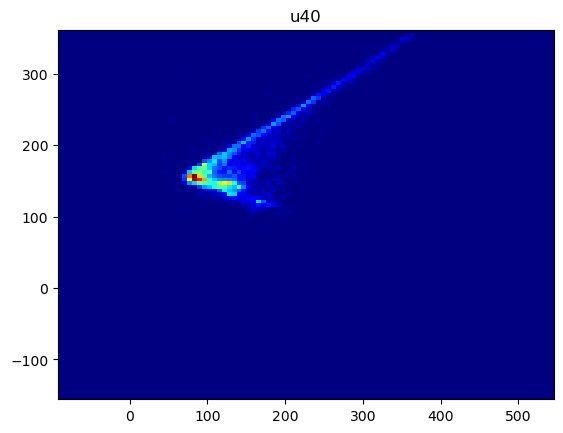

In [49]:
listy = list(range(0, len(AoI("u", 40)[1])))
likelihoods = calculate_likelihood("u", 40, [3])

In [50]:
print(likelihoods)

(array([[0.99877875]]), array([[0.90416816]]), array([0.99]), array([0.46682822]))


In [51]:
print(np.amax(likelihoods), np.argmax(likelihoods))

0.9987787494629933 0


C:\Users\alexg\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\alexg\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [52]:
def find_accuracy_likelihoods(plane, event):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event)
    
    likelihoods = [None] * len(AoI_z)
    prob_lz = [None] * len(AoI_z)
    prob_rphi = [None] * len(AoI_z)
    prob_quad = [None] * len(AoI_z)
    
    delta_z = np.array(AoI_truevtxz) - np.array(AoI_z)
    delta_x = np.array(AoI_truevtxx) - np.array(AoI_x)
    delta_r2 = np.sqrt(delta_z**2 + delta_x**2)
    
    for i in tqdm(range(len(AoI_z))):
        likelihoods[i], prob_lz[i], prob_rphi[i], prob_quad[i] = calculate_likelihood(plane, event, [i])
    
    #print(prob_lz)
    #print(prob_rphi)
    #print(prob_quad)
    
    plt.clf()
    plt.scatter(delta_r2, likelihoods, s=5)
    plt.title(str(plane)+str(event)+" plane")
    plt.xlabel("|R|")
    plt.ylabel("Likelihoods")
    plt.show()
    
    return delta_r2, likelihoods, prob_lz, prob_rphi, prob_quad

  1%|▍                                                                                 | 3/599 [00:03<10:04,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  1%|▋                                                                                 | 5/599 [00:05<10:07,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  2%|█▍                                                         

 30%|███████████████████████▉                                                        | 179/599 [03:03<07:21,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 31%|████████████████████████▊                                                       | 186/599 [03:10<07:03,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 31%|████████████████████████▉                                  

 54%|███████████████████████████████████████████▌                                    | 326/599 [05:33<04:39,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 55%|███████████████████████████████████████████▊                                    | 328/599 [05:35<04:37,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 55%|███████████████████████████████████████████▉                                    | 329/599 [05:36<04:36,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in 

 78%|██████████████████████████████████████████████████████████████▏                 | 466/599 [07:55<02:14,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 78%|██████████████████████████████████████████████████████████████▎                 | 467/599 [07:56<02:13,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 78%|███████████████████████████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████████▌| 596/599 [10:07<00:03,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_5820\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
100%|████████████████████████████████████████████████████████████████████████████████| 599/599 [10:10<00:00,  1.02s/it]


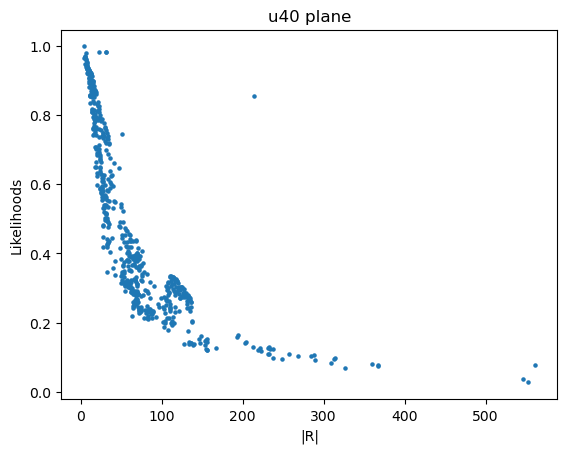

In [53]:
likelihoods_accuracy = find_accuracy_likelihoods("u", 40)

In [54]:
#delta_r2, likelihoods, prob_lz, prob_rphi, prob_quad = find_accuracy_likelihoods("u", 556)
print(likelihoods_accuracy[2])

[array([[0.86658169]]), array([[0.86464482]]), array([[0.76157477]]), array([[0.90416816]]), array([[0.9023546]]), array([[0.90053248]]), array([[0.89870279]]), array([[0.89686521]]), array([[0.89501997]]), array([[0.89316753]]), array([[0.89130784]]), array([[0.88944137]]), array([[0.88756835]]), array([[0.88568857]]), array([[0.88380266]]), array([[0.88191055]]), array([[0.88001273]]), array([[0.87810941]]), array([[0.87620025]]), array([[0.87428628]]), array([[0.87236704]]), array([[0.87044315]]), array([[0.86851453]]), array([[0.86658169]]), array([[0.86464482]]), array([[0.86270359]]), array([[0.86075904]]), array([[0.85881069]]), array([[0.85685916]]), array([[0.85490453]]), array([[0.85294687]]), array([[0.85098682]]), array([[0.84902387]]), array([[0.84705909]]), array([[0.84509198]]), array([[0.84312318]]), array([[0.84115276]]), array([[0.83918078]]), array([[0.83720789]]), array([[0.83523372]]), array([[0.83325892]]), array([[0.83128341]]), array([[0.82930769]]), array([[0.8

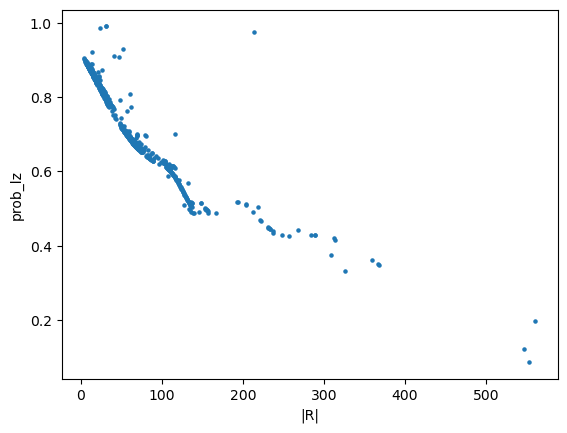

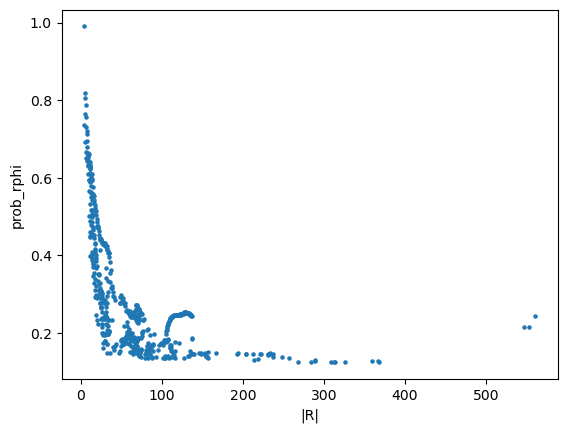

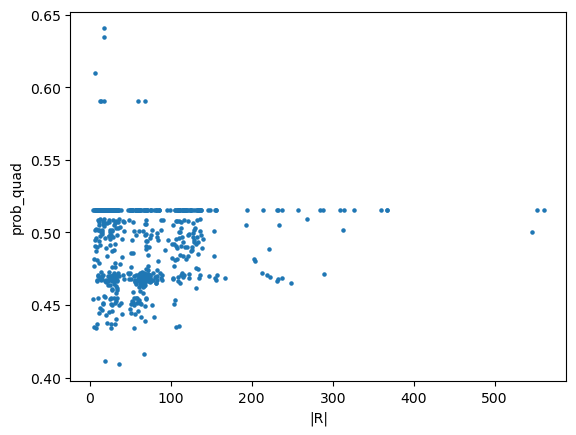

In [55]:


plt.scatter(likelihoods_accuracy[0], likelihoods_accuracy[2], s=5)
plt.xlabel("|R|")
plt.ylabel("prob_lz")
plt.show()

plt.scatter(likelihoods_accuracy[0], likelihoods_accuracy[3], s=5)
plt.xlabel("|R|")
plt.ylabel("prob_rphi")
plt.show()

plt.scatter(likelihoods_accuracy[0], likelihoods_accuracy[4], s=5)
plt.xlabel("|R|")
plt.ylabel("prob_quad")
plt.show()

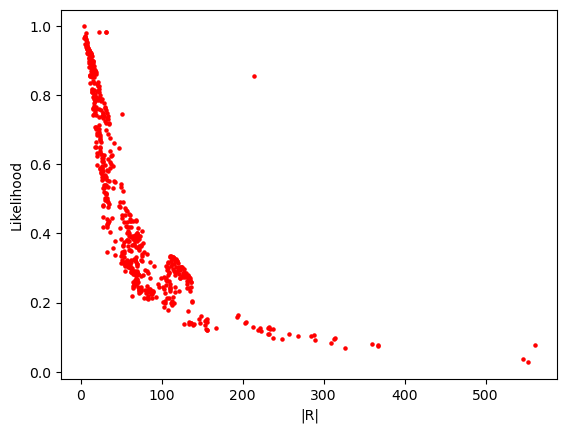

In [56]:

plt.scatter(likelihoods_accuracy[0], likelihoods_accuracy[1], s=5, color="red")
#plt.plot([4, 4], [0, 1])
plt.xlabel("|R|")
plt.ylabel("Likelihood")
plt.show()